<a href="https://colab.research.google.com/github/haizznaam/Risk-Analysis-NEU/blob/main/MBB_TCB_VaR_Estimation_and_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Market Risk - Risk Analysis Course - NEU
****
**Yêu cầu chi tiết:**

1. **Lựa chọn danh mục đầu tư:** Mỗi nhóm được tự do lựa chọn 1 danh mục đầu tư gồm 2 tài sản (chẳng hạn như cổ phiếu) với dữ liệu giả định.
2. **Ước lượng VaR:**
    - 1. Sử dụng phương pháp BHS để mô phỏng chuỗi lợi suất (returns) cho danh mục đầu tư. (Non-parametric)

    - 2. Sử dụng phân phối chuẩn để ước tính VaR 1 ngày với độ tin cậy 99%. (Parametric)
3. **Hậu kiểm:**
    - Thực hiện hậu kiểm cho phương pháp BHS với 250 dữ liệu.
    - Áp dụng các kiểm định không điều kiện và có điều kiện để đánh giá hiệu quả của phương pháp trong việc dự đoán VaR.

    ***

# Environmetal Settings

In [260]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm
from scipy.stats import kurtosis, skew
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Stock Dataset

In [261]:
import os
os.chdir("/content/drive/MyDrive/Risk Analysis - Spring 2024_NEU/Market Risk")
print("We are currently in ", os.getcwd())

We are currently in  /content/drive/MyDrive/Risk Analysis - Spring 2024_NEU/Market Risk


In [262]:
mbb = pd.read_csv("stock-dataset/MBB.csv")[['Ngày', 'Lần cuối']]
mbb = mbb.rename(columns={'Ngày': 'Date', 'Lần cuối': 'Last Price'})
mbb['Last Price'] = mbb['Last Price'].apply(lambda x: float(x.replace(',', '.')))
mbb['Date'] = pd.to_datetime(mbb['Date'])
mbb.head()

<ipython-input-262-2d43a9460fa6>:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  mbb['Date'] = pd.to_datetime(mbb['Date'])


,Date,Last Price
0,2023-12-29,18.65
1,2023-12-28,18.55
2,2023-12-27,18.40
3,2023-12-26,18.45
4,2023-12-25,18.40


In [263]:
tcb = pd.read_csv("stock-dataset/TCB.csv")[['Ngày', 'Lần cuối']]
tcb = tcb.rename(columns={'Ngày': 'Date', 'Lần cuối': 'Last Price'})
tcb['Last Price'] = tcb['Last Price'].apply(lambda x: float(x.replace(',', '.')))
tcb['Date'] = pd.to_datetime(tcb['Date'])
tcb.head()

<ipython-input-263-1eae70b71dcd>:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tcb['Date'] = pd.to_datetime(tcb['Date'])


,Date,Last Price
0,2023-12-29,31.80
1,2023-12-28,31.50
2,2023-12-27,30.85
3,2023-12-26,30.80
4,2023-12-25,30.95


In [264]:
mbb.columns = ['Date', 'MBB']
mbb.set_index('Date', inplace=True)
mbb.head()

,MBB
Date,
2023-12-29,18.65
2023-12-28,18.55
2023-12-27,18.40
2023-12-26,18.45
2023-12-25,18.40


In [265]:
tcb.columns = ['Date', 'TCB']
tcb.set_index('Date', inplace=True)
tcb.head()

,TCB
Date,
2023-12-29,31.80
2023-12-28,31.50
2023-12-27,30.85
2023-12-26,30.80
2023-12-25,30.95


In [266]:
stocks = pd.concat([mbb, tcb], axis=1)
stocks.head()

,MBB,TCB
Date,,
2023-12-29,18.65,31.80
2023-12-28,18.55,31.50
2023-12-27,18.40,30.85
2023-12-26,18.45,30.80
2023-12-25,18.40,30.95


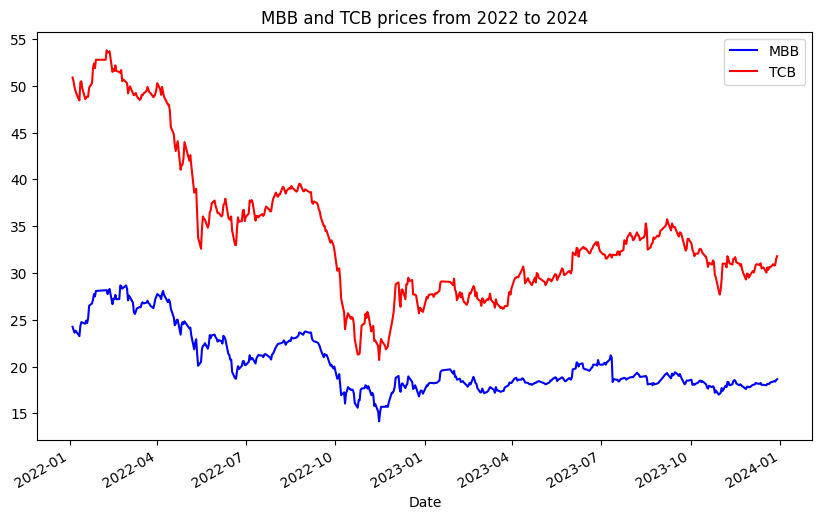

In [267]:
stocks.plot(figsize=(10, 6), color = ['blue', 'red'])
plt.title('MBB and TCB prices from 2022 to 2024')
plt.show()

# Set an Investment Weights (Đặt trọng số tùy ý)

In [268]:
weights = np.array([0.4, 0.6]) # portfolio = 0.4* MBB + 0.6 * TCB

# Initial Investment Amount

In [269]:
initial_investment = 100_000 # (100tr VND)
mbb_invest_amount = initial_investment * weights[0]
tcb_invest_amount = initial_investment * weights[1]

# Calculate Log of Percentage Change

In [270]:
stocks_returns = np.log(1 + stocks.pct_change(1)).dropna()
stocks_returns.head()

,MBB,TCB
Date,,
2023-12-28,-0.005376,-0.009479
2023-12-27,-0.008119,-0.020851
2023-12-26,0.002714,-0.001622
2023-12-25,-0.002714,0.004858
2023-12-22,-0.005450,-0.011373



Kết quả của `stocks_returns` sẽ là một DataFrame mới chứa tỷ lệ phần trăm thay đổi logarit của giá trị cho mỗi cặp giá trị liền kề trong các cột `mbb`,  `TCB`.

**Ý nghĩa:**

- `stocks_returns` cung cấp cho ta thông tin về mức độ biến động của cổ phiếu trong danh mục đầu tư theo thời gian.

- Giá trị dương cho thấy giá trị cổ phiếu đã tăng so với giá trị trước đó, trong khi giá trị âm cho thấy giá trị cổ phiếu đã giảm.

- Việc sử dụng logarit tự nhiên giúp ổn định dữ liệu và dễ dàng so sánh mức độ biến động giữa các cột khác nhau.

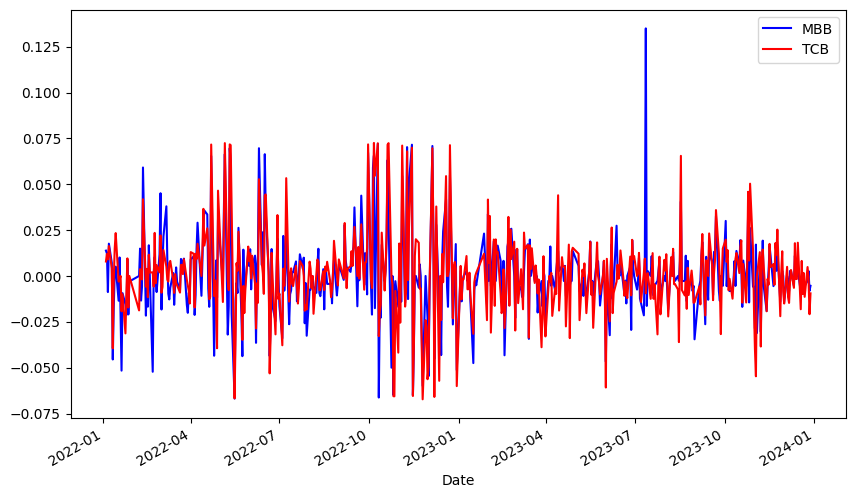

In [271]:
stocks_returns.plot(figsize=(10, 6), color = ['blue', 'red'])
plt.show()

# **I. VaR Estimation**

## **1. Parametric Method (Normal Distribution)**

Estimating VaR with Normally Distributed Profits/Losses:

$$\text{VaR}(\alpha) = -\mu + \sigma \times z_{\alpha}$$

where $z_{\alpha}$ is the standard normal variate corresponding to $\alpha$.

### Create a Covariance Matrix Based on Returns

In [272]:
# Generate Var-Cov Matrix
cov_matrix = stocks_returns.cov()
cov_matrix

,MBB,TCB
MBB,0.000479,0.000380
TCB,0.000380,0.000511


### Calculate the Portfolio Mean and Standard Deviation

In [273]:
# Calculate average return
avg_returns = stocks_returns[['MBB','TCB']].mean()

# Calculate mean returns for portfolio overall
# using dot product to normalize individual means against investment weights
portfolio_mean = avg_returns.dot(weights)

# Calculate standard deviation of portfolio
portfolio_std = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Investment Mean
investment_mean = (1 + portfolio_mean) * initial_investment

# Standard Deviation of Investment
investment_std = initial_investment * portfolio_std

print('=' * 40)
print("Portfolio mean is equal to", int(investment_mean))
print("Portfolio standard deviation is equal to", round(investment_std, 2))

Portfolio mean is equal to 100077
Portfolio standard deviation is equal to 2105.28


### Inverse of the Normal Cumulative Distribution with a specifiedd Confidence Interval, Standard Devitation and Mean

In [274]:
# Select your confidence interval
conf_level = 0.01

# Scipy ppf method is a method to generate values for the
# inverse cumulative distribution function to a normal distribution
# plugging the mean, std of our portfolio

cutoff = investment_mean + investment_std * norm.ppf(0.01)
cutoff

95180.2971307638

### **Estimating Value at Risk (VaR)**

In [275]:
# Calculate VaR
VaR_1day = initial_investment - cutoff
print(f"Portfolio Value at Risk is equal to {int(VaR_1day)}k VND, which is {round(VaR_1day/initial_investment*100,2)} percent of initial investment")

portfolio_returns = mbb_invest_amount * stocks_returns['MBB'] + tcb_invest_amount * stocks_returns['TCB']
count_exceed_portfolio = len(portfolio_returns[portfolio_returns < -VaR_1day])
print("Number of days Portfolio returns exceed VaR:", count_exceed_portfolio)

Portfolio Value at Risk is equal to 4819k VND, which is 4.82 percent of initial investment
Number of days Portfolio returns exceed VaR: 9


**It means with 99% of confidence a 100 million VND portfolio will not exceed losses greather than 4.82 million VND over a one day period.**

Similarly, we can estimate VaR of MBB and TCB investments.

In [276]:
mbb_stock = stocks_returns['MBB'].values
mbb_returns_mean = mbb_stock.mean()
mbb_returns_std = mbb_stock.std()

# MBB Investment Mean
mbb_investment_mean = (1 + mbb_returns_mean) * mbb_invest_amount

# MBB Standard Deviation of Investment
mbb_investment_std = mbb_invest_amount * mbb_returns_std

print('=' * 40)
print("MBB asset mean is equal to", int(mbb_investment_mean))
print("MBB asset standard deviation is equal to", round(mbb_investment_std, 2))

print('=' * 40)
mbb_cutoff = mbb_investment_mean + mbb_investment_std * norm.ppf(0.01)
VaR_mbb_1day = mbb_invest_amount - mbb_cutoff
print(f"MBB Value at Risk is equal to {int(VaR_mbb_1day)}k VND, which is {round(VaR_mbb_1day/mbb_invest_amount*100,2)} percent of initial investment")

mbb_returns = mbb_invest_amount * stocks_returns['MBB']
count_exceed_mbb = len(mbb_returns[mbb_returns < -VaR_mbb_1day])
print("Number of days MBB returns exceed VaR:", count_exceed_mbb)

MBB asset mean is equal to 40021
MBB asset standard deviation is equal to 874.8
MBB Value at Risk is equal to 2013k VND, which is 5.03 percent of initial investment
Number of days MBB returns exceed VaR: 9


In [277]:
tcb_stock = stocks_returns['TCB'].values
tcb_returns_mean = tcb_stock.mean()
tcb_returns_std = tcb_stock.std()

# TCB Investment Mean
tcb_investment_mean = (1 + tcb_returns_mean) * tcb_invest_amount

# TCB Standard Deviation of Investment
tcb_investment_std = tcb_invest_amount * tcb_returns_std

print("=" * 40)
print("TCB asset mean is equal to", int(tcb_investment_mean))
print("TCB asset standard deviation is equal to", round(tcb_investment_std, 2))

print("=" * 40)
tcb_cutoff = tcb_investment_mean + tcb_investment_std * norm.ppf(0.01)
VaR_tcb_1day = tcb_invest_amount - tcb_cutoff
print(f"TCB Value at Risk is equal to {int(VaR_tcb_1day)}k VND, which is {round(VaR_tcb_1day/tcb_invest_amount*100,2)} percent of initial investment")

tcb_returns = tcb_invest_amount * stocks_returns['TCB']
count_exceed_tcb = len(tcb_returns[tcb_returns < -VaR_tcb_1day])
print("Number of days TCB returns exceed VaR:", count_exceed_tcb)


TCB asset mean is equal to 60056
TCB asset standard deviation is equal to 1355.31
TCB Value at Risk is equal to 3096k VND, which is 5.16 percent of initial investment
Number of days TCB returns exceed VaR: 12


In [278]:
# Create a list of assets
assets = ['MBB', 'TCB', 'Portfolio']  # Assuming 'Danh muc' refers to the total

# Create a list of exchange rates
returns = [int(mbb_invest_amount), int(tcb_invest_amount), int(initial_investment)]  # Assuming values in millions

# Create a list of VaR values
var_values = [round(VaR_mbb_1day, 1), round(VaR_tcb_1day, 1), round(VaR_1day, 1)]  # Assuming values with decimals

# Create a DataFrame
df = pd.DataFrame(list(zip(assets, returns, var_values)), columns = ['Asset', 'Amount (thoundsand VND)', 'VaR (99%, 1 day)'])

# Print the DataFrame
print("Parametric Method (Normal Distribution)")

df

Parametric Method (Normal Distribution)


,Asset,Amount (thoundsand VND),"VaR (99%, 1 day)"
0,MBB,40000,2014.0
1,TCB,60000,3096.1
2,Portfolio,100000,4819.7


### Distribution

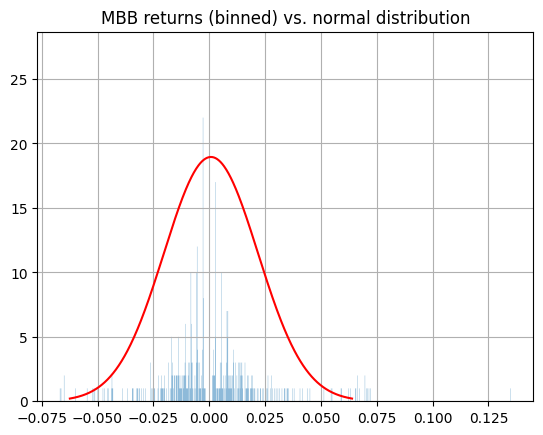

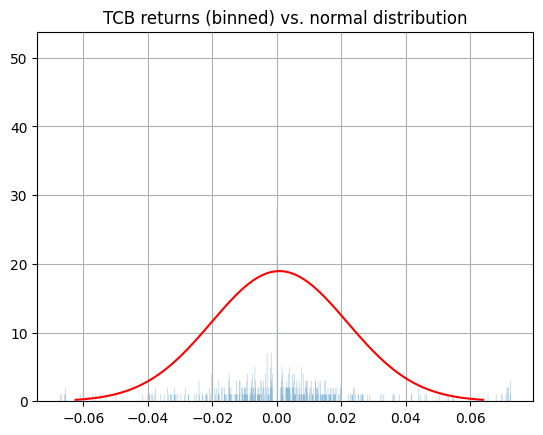

In [279]:
stocks_names = ['MBB', 'TCB']

for name in stocks_names:
  stocks_returns[name].hist(bins = 1000, histtype = 'stepfilled', alpha = 0.5)
  x = np.linspace(portfolio_mean - 3*portfolio_std, portfolio_mean+3*portfolio_std,len(stocks_returns[name]))

  ymax = stocks[name].max()
  plt.ylim(0, ymax)
  plt.plot(x, norm.pdf(x, portfolio_mean, portfolio_std), "r")
  plt.title("{} returns (binned) vs. normal distribution".format(name))
  plt.show()

In [280]:
stocks_returns[['MBB']]

,MBB
Date,
2023-12-28,-0.005376
2023-12-27,-0.008119
2023-12-26,0.002714
2023-12-25,-0.002714
2023-12-22,-0.005450
...,...
2022-01-10,0.007157
2022-01-07,0.017609
2022-01-06,-0.008766


## **2. Boostrap Historical Simulation Method**

In [281]:
# Convert Returns into P&L (Profit and Loss)
PnL= (weights * stocks_returns.values).sum(axis=1)
print(PnL.shape)
PnL

(497,)


array([-7.83778919e-03, -1.57581271e-02,  1.12246126e-04,  1.82950314e-03,
       -9.00363601e-03, -2.31260760e-03, -5.90168693e-03,  4.92209487e-03,
       -1.42019299e-02,  1.19919795e-02, -9.81194004e-04, -9.82801203e-04,
        1.51310330e-02, -6.07504254e-03,  3.04216262e-03, -8.44354889e-04,
       -1.21177419e-02, -8.05446986e-03,  2.98755804e-03, -1.45865664e-02,
       -5.06332119e-03,  9.20295060e-03,  1.00250650e-03, -1.88069276e-02,
        2.08069294e-02,  8.06685031e-03,  1.40962232e-02, -1.80848409e-03,
        1.66743655e-03,  7.31615892e-03,  1.70411166e-02, -1.76623235e-03,
       -3.11379332e-03, -1.91997900e-02,  6.89502535e-04,  1.63363691e-02,
        5.68724637e-03, -3.52522154e-02,  1.11489804e-02, -1.24479635e-02,
       -2.59790216e-02, -3.54444433e-02, -1.30661070e-02,  6.25625011e-03,
        4.06390223e-02, -7.17316136e-04,  4.12614502e-02,  5.11860558e-03,
       -1.09157521e-02,  7.22764422e-03, -1.54868267e-02,  1.38919213e-02,
        1.73345784e-02,  

In [282]:
historical_var_perc = np.percentile(PnL, 1, interpolation='lower')
historical_var_perc

-0.057656955382297155

In [283]:
historical_var = historical_var_perc * initial_investment

print(f'The historical VaR is {round(abs(historical_var), 1)}')

The historical VaR is 5765.7


Similarly, we can estimate VaR of MBB and TCB by BHS method

In [284]:
# HS - MBB
mbb_PnL= (weights[0] * mbb_stock)

mbb_historical_var_perc = np.percentile(mbb_PnL, 1, interpolation='lower')
mbb_historical_var = mbb_historical_var_perc * mbb_invest_amount

print(f'The MBB historical VaR is {round(abs(mbb_historical_var), 1)}')

The MBB historical VaR is 958.4


In [285]:
# HS - TCB
tcb_PnL= (weights[1] * tcb_stock)

tcb_historical_var_perc = np.percentile(tcb_PnL, 1, interpolation='lower')
tcb_historical_var = tcb_historical_var_perc * tcb_invest_amount

print(f'The TCB historical VaR is {round(abs(tcb_historical_var), 1)}')

The TCB historical VaR is 2360.2


### Kurtosis and Skew

In [287]:

# A normal distribution should have a zero skew and more importantly,
# zero kurtosis (technically 3, but SciPy subtracts 3 to normalize it)
# So the distribution of our return does have fat tails
print(f"Skew is {round(skew(PnL),2)}")
print(f"Kurtosis is {round(kurtosis(PnL),2)}")

Skew is 0.57
Kurtosis is 2.69


### **Boostrap VaR**

In [288]:
def VaR99(data):
  return np.percentile(data, 1, interpolation='lower')

def boostrap(data, func):
  sample = np.random.choice(data, len(data))
  return func(sample)

def draw_bs_reps(data, func, size):
  """Draw bootstrap replicates."""
  bs_replicates = np.empty(size)

  for i in range(size):
    bs_replicates[i] = boostrap(data, func)
  return bs_replicates

In [289]:
boostrap_VaR_perc = draw_bs_reps(PnL, VaR99, 1000)

bs_VaR = abs(boostrap_VaR_perc) * initial_investment

print(f'The boostrap VaR is {round(np.mean(bs_VaR), 1)}')

The boostrap VaR is 5820.8


<ipython-input-288-bc4643a6dcad>:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return func(sample)


In [290]:
mbb_boostrap_VaR_perc = draw_bs_reps(mbb_PnL, VaR99, 1000)

mbb_bs_VaR = abs(mbb_boostrap_VaR_perc) * mbb_invest_amount
print(f'The MBB boostrap VaR is {round(np.mean(mbb_bs_VaR), 1)}')

<ipython-input-288-bc4643a6dcad>:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return func(sample)


The MBB boostrap VaR is 937.3


In [291]:
tcb_boostrap_VaR_perc = draw_bs_reps(tcb_PnL, VaR99, 1000)

tcb_bs_VaR = abs(tcb_boostrap_VaR_perc) * tcb_invest_amount
print(f'The TCB boostrap VaR is {round(np.mean(tcb_bs_VaR), 1)}')

<ipython-input-288-bc4643a6dcad>:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return func(sample)


The TCB boostrap VaR is 2293.2


In [292]:
# Create a list of assets
assets = ['MBB', 'TCB', 'Portfolio']  # Assuming 'Danh muc' refers to the total

# Create a list of exchange rates
returns = [int(mbb_invest_amount), int(tcb_invest_amount), int(initial_investment)]  # Assuming values in millions

# Create a list of VaR values
var_values = [round(np.mean(mbb_bs_VaR), 1), round(np.mean(tcb_bs_VaR), 1), round(np.mean(bs_VaR), 1)]  # Assuming values with decimals

# Create a DataFrame
df = pd.DataFrame(list(zip(assets, returns, var_values)), columns = ['Asset', 'Amount (thoundsand VND)', 'VaR (99%, 1 day)'])

# Print the DataFrame
print("Boostrap Historical Simulation Method (BHS)")

df

Boostrap Historical Simulation Method (BHS)


,Asset,Amount (thoundsand VND),"VaR (99%, 1 day)"
0,MBB,40000,937.3
1,TCB,60000,2293.2
2,Portfolio,100000,5820.8


Text(0, 0.5, 'PDF')

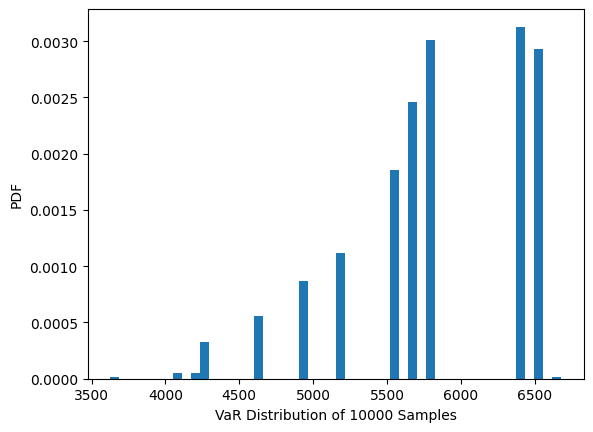

In [293]:
plt.hist(bs_VaR, bins=50, density=True)
plt.xlabel("VaR Distribution of 10000 Samples")
plt.ylabel("PDF")

### Confidence interval

In [294]:
conf_intervals = np.percentile(bs_VaR, [1.0, 99.0])

print(f"The 99% Boostrap VaR confidence interval is {conf_intervals}")

The 99% Boostrap VaR confidence interval is [4279.31699553 6530.39356272]


# **II. Backtesting**

**Hậu kiểm:**

- Thực hiện hậu kiểm cho phương pháp BHS với 250 dữ liệu.
- Áp dụng các kiểm định không điều kiện và có điều kiện để đánh giá hiệu quả của phương pháp trong việc dự đoán VaR.

The backtesting methods reviewed can be grouped into different categories:

- **Unconditional test methods**: Kupiec’s POF (1995) test, Kupiec’s TUFF test,
binomial distribution test, the Basel Committee’s traffic light test, the simplest backtesting method, the proportion of failures test (Haas, 2001), the scaled Crnkovic and
Drachman (1996)’s method (Haas, 2001), the risk map (Colletaz et al., 2013), the
quality control of risk measure (de la Pena et al., 2006) and the multivariate test
(Perignon and Smith, 2008).

- **Conditional test methods**: Joint test, the time between failures likelihood ratio
test (Haas, 2001), the generalized Markov tests (Pajhede, 2015), the multivariate autocorrelations test (Hurlin and Tokpavi, 2006), the dynamic binary tests (Dumitrescu
et al., 2012).

- **Independence property test methods**: the independence test (Christoffersen,
1998) and Wald statistic test (Engle and Managanelli, 2004)

**Select the first 250 data points for backtesting**

In [295]:
stocks_returns['portfolio'] = weights[0] * stocks_returns['MBB'] + weights[1] * stocks_returns['TCB']
stocks_returns.head()

,MBB,TCB,portfolio
Date,,,
2023-12-28,-0.005376,-0.009479,-0.007838
2023-12-27,-0.008119,-0.020851,-0.015758
2023-12-26,0.002714,-0.001622,0.000112
2023-12-25,-0.002714,0.004858,0.001830
2023-12-22,-0.005450,-0.011373,-0.009004


**Christoffesen test**

In [302]:
from scipy.stats import binom

# Calculate the expected number of exceedances under the null hypothesis
expected_exceedances = len(returns) * (1 - confidence_level)

# Perform Christoffersen's Test
christoffersen_p_value = 1 - binom.cdf(unconditional_VaR_exceedances - 1, len(returns), confidence_level)

print("Christoffersen's Test p-value:", christoffersen_p_value)

Christoffersen's Test p-value: 1.0


**Kupiec test**

In [303]:
from scipy.stats import chi2
epsilon = 1e-10
proportion_exceedances = unconditional_VaR_exceedances / len(returns) + epsilon

# Perform Kupiec's Test
kupiec_statistic = -2 * (len(returns) * np.log(1 - confidence_level) - unconditional_VaR_exceedances * np.log(proportion_exceedances))
kupiec_p_value = 1 - chi2.cdf(kupiec_statistic, 1)  # 1 degree of freedom

print("Kupiec's Test p-value:", kupiec_p_value)

Kupiec's Test p-value: 0.00020166451871539426


### Statiscal test

In [304]:
from scipy.stats import ttest_ind

# T-test to compare the means of two independent samples
t_stat, p_value = ttest_ind(stocks_returns['MBB'], stocks_returns['TCB'])
print("T-test results: t-statistic =", t_stat, ", p-value =", p_value)

T-test results: t-statistic = -0.2962022635956751 , p-value = 0.7671376171691983


In [305]:
from scipy.stats import f_oneway

f_stat, p_value = f_oneway(stocks_returns['MBB'], stocks_returns['TCB'])
print("ANOVA test results: F-statistic =", f_stat, ", p-value =", p_value)

ANOVA test results: F-statistic = 0.08773578095920175 , p-value = 0.7671376171691706


In [306]:
from scipy.stats import chi2_contingency

# Create a contingency table
data = [[(stocks_returns['MBB'] > 0).sum(), (stocks_returns['MBB'] <= 0).sum()],
        [(stocks_returns['TCB'] > 0).sum(), (stocks_returns['TCB'] <= 0).sum()]]

chi_stat, p_value, dof, expected = chi2_contingency(data)
print("Chi-square test results: chi2 =", chi_stat, ", p-value =", p_value)

Chi-square test results: chi2 = 2.3345797060082774 , p-value = 0.12652913696276324


****

**Viotality and Returns**

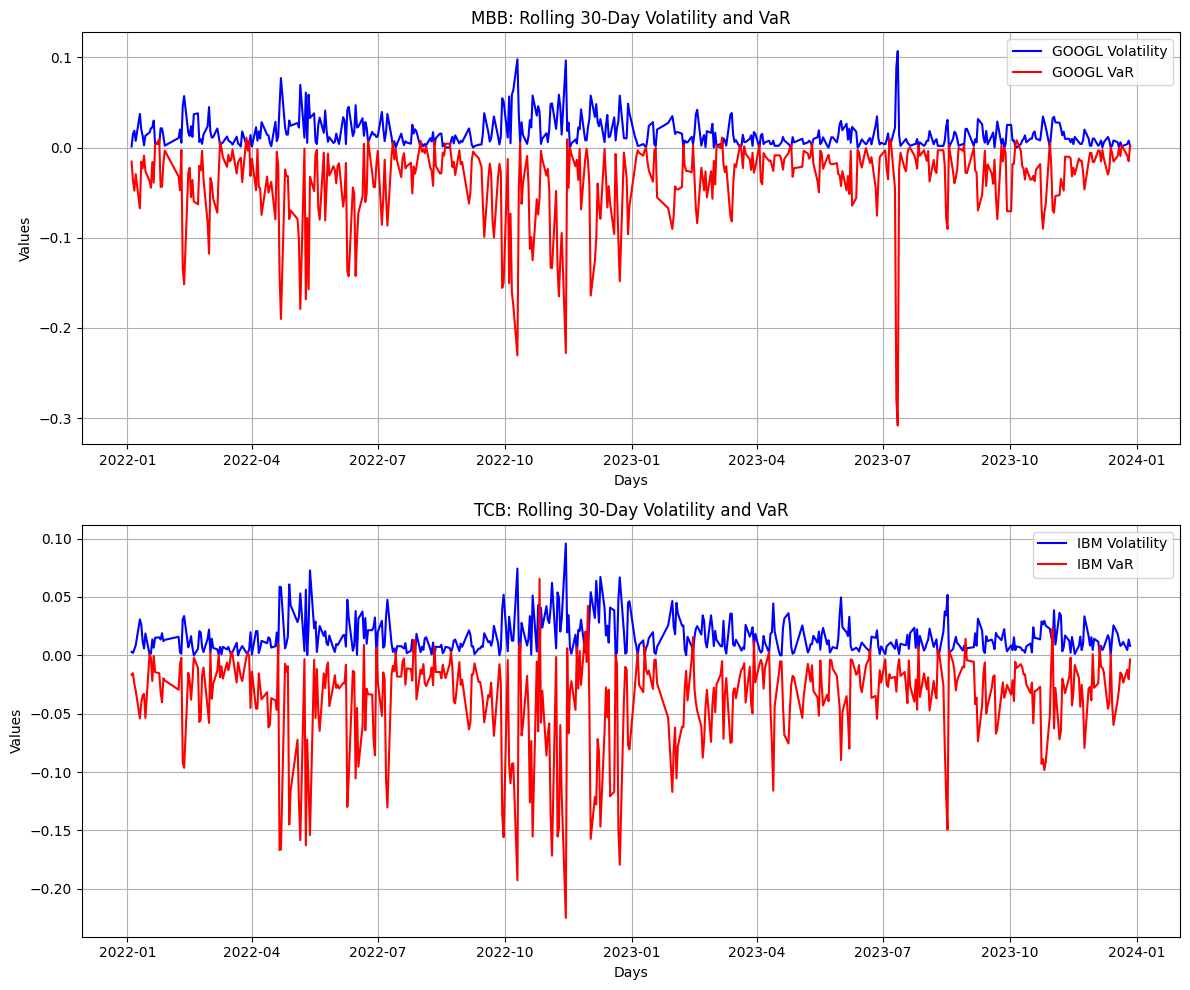

In [307]:
# Define rolling window size
window_size = 2

# Define confidence level for VaR
confidence_level = 0.99
z_score = norm.ppf(confidence_level)

# Calculate rolling metrics for MBB
stocks_returns['MBB_volatility'] = stocks_returns['MBB'].rolling(window_size).std()
stocks_returns['mbb_returns_mean'] = stocks_returns['MBB'].rolling(window_size).mean()
stocks_returns['MBB_VaR'] = -(stocks_returns['mbb_returns_mean'] + z_score * stocks_returns['MBB_volatility'])

# Calculate rolling metrics for TCB
stocks_returns['TCB_volatility'] = stocks_returns['TCB'].rolling(window_size).std()
stocks_returns['tcb_returns_mean'] = stocks_returns['TCB'].rolling(window_size).mean()
stocks_returns['TCB_VaR'] = -(stocks_returns['tcb_returns_mean'] + z_score * stocks_returns['TCB_volatility'])

# Create figure and plot space
plt.figure(figsize=(12, 10))

# Plotting MBB Volatility and VaR
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(stocks_returns['MBB_volatility'], label='GOOGL Volatility', color='blue')
plt.plot(stocks_returns['MBB_VaR'], label='GOOGL VaR', color='red')
plt.title('MBB: Rolling 30-Day Volatility and VaR')
plt.xlabel('Days')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Plotting TCB Volatility and VaR
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(stocks_returns['TCB_volatility'], label='IBM Volatility', color='blue')
plt.plot(stocks_returns['TCB_VaR'], label='IBM VaR', color='red')
plt.title('TCB: Rolling 30-Day Volatility and VaR')
plt.xlabel('Days')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Uncoditional Testing

In [424]:
recent_df = stocks_returns[-250:]

# Confidence levels to test
confidence_levels = [0.99, 0.95, 0.90]
results = []

# Function to calculate VaR and count violations
def calculate_var_and_violations(returns, confidence_level):
    VaR = np.percentile(recent_df, 100 * (1 - confidence_level))
    violations = sum(returns < VaR)
    return VaR, violations

# Run Kupiec's test for each confidence level
for level in confidence_levels:
    VaR, violations = calculate_var_and_violations(recent_df['portfolio'], level)
    n = 250  # Fixed sample size
    p_hat = violations / n
    p = 1 - level
    LRuc = (((1 - p) ** (n - violations)) * (p ** violations)) + 2 * np.log(((1 - p_hat) ** (n - violations)) * (p_hat ** violations))
    chi_square = -2 * np.log(LRuc)  # The Kupiec LRuc is essentially a chi-square statistic
    p_value = 1 - chi2.cdf(LRuc, 1)
    test_outcome = 'Reject H0' if p_value < 1 - level else 'Not Reject H0'
    results.append([level, VaR, violations, LRuc, chi_square ,p_value, test_outcome])
# Create DataFrame from results
print('Kupiec Uncoditional Test for Parametric VaR')
results_df = pd.DataFrame(results, columns=['Confidence Level', 'VaR', 'Violations', 'LRUC','Chi-Square', 'P-Value','Test Outcome'])
results_df

Kupiec Uncoditional Test for Parametric VaR


<ipython-input-424-2773e3ae3a38>:20: RuntimeWarning: invalid value encountered in log
  chi_square = -2 * np.log(LRuc)  # The Kupiec LRuc is essentially a chi-square statistic


,Confidence Level,VaR,Violations,LRUC,Chi-Square,P-Value,Test Outcome
0,0.99,-0.154605,0,0.081059,5.025168,0.775868,Not Reject H0
1,0.95,-0.066812,0,0.000003,25.646647,0.998690,Not Reject H0
2,0.90,-0.043730,9,-77.508295,NaN,1.000000,Not Reject H0


In [422]:
# Define function to calculate VaR and count violations for BHS method
def calculate_var_and_violations_BHS(returns, confidence_level):
    # Calculate VaR directly from historical returns
    VaR_BHS = np.percentile(returns, 100 * (1 - confidence_level))

    # Count violations based on original returns and VaR estimate
    violations_BHS = np.sum(returns < VaR_BHS)  # Counting instances where returns are less than negative VaR

    return VaR_BHS, violations_BHS


# Confidence levels to test
confidence_levels = [0.99, 0.95, 0.90]
BHS_results = []

# Run Kupiec's test for BHS method for each confidence level
for level in confidence_levels:
    # Calculate VaR and violations for BHS Method
    VaR_BHS, violations_BHS = calculate_var_and_violations_BHS(pnl_sample, level)
    n = 250  # Fixed sample size

    # Avoid division by zero by adding a small value to violations
    p_hat_BHS = (violations_BHS ) / (n)
    p_BHS = 1 - level

    # Calculate LRUC with handling division by zero
    LRuc_BHS = (((1 - p_BHS) ** (n - violations_BHS)) * (p_BHS ** violations_BHS)/((p_hat_BHS**violations_BHS *(1 - p_BHS)**(250-violations_BHS))))


    # The Kupiec LRuc is essentially a chi-square statistic
    chi_square_BHS = -2 * np.log(LRuc_BHS)
    p_value_BHS = 1 - chi2.cdf(LRuc_BHS, 1)
    test_outcome = 'Reject H0' if p_value_BHS < 1 - level else 'Not Reject H0'
    BHS_results.append([level, VaR_BHS, violations_BHS, LRuc_BHS,chi_square_BHS ,p_value_BHS, test_outcome])

# Create DataFrame from results for BHS Method
BHS_results_df = pd.DataFrame(BHS_results, columns=['Confidence Level', 'VaR', 'Violations', 'LRUC', 'Chi-Square','P-Value', 'Test Outcome'])
print("\nKupiec Unconditional Test for BHS VaR")
BHS_results_df



Kupiec Unconditional Test for BHS VaR


,Confidence Level,VaR,Violations,LRUC,Chi-Square,P-Value,Test Outcome
0,0.99,-0.064794,3,0.578704,1.093929e+00,0.446821,Not Reject H0
1,0.95,-0.039839,13,0.600574,1.019739e+00,0.438359,Not Reject H0
2,0.90,-0.025037,25,1.000000,1.398881e-14,0.317311,Not Reject H0


## Conditional Test

In [378]:
def calculate_var_and_violations(returns, confidence_level):
    # Calculate VaR
    VaR = np.percentile(returns, 100 * (1 - confidence_level))

    # Initialize counts for scenarios
    n00 = 0  # True positive (no violation)
    n01 = 0  # False positive (violation)
    n10 = 0  # False negative (no violation)
    n11 = 0  # True negative (violation)

    # Iterate over returns data to count scenarios
    for i in range(1, len(returns)):
        # Determine the state of returns for the current and previous days
        current_state = returns[i] < -VaR
        previous_state = returns[i - 1] < -VaR

        # Update counts based on transition between states
        if current_state and previous_state:
            n00 += 1
        elif current_state and not previous_state:
            n01 += 1
        elif not current_state and previous_state:
            n10 += 1
        elif not current_state and not previous_state:
            n11 += 1

    # Calculate total violations
    violations = n01 + n11

    return VaR, violations, n00, n01, n10, n11


In [382]:
# Run Kupiec's test for each confidence level
confidence_levels = [0.99, 0.95, 0.90]
results = []
for level in confidence_levels:
    VaR, violations, n00, n01, n10, n11 = calculate_var_and_violations(recent_df['portfolio'], level)
    n = 250  # Fixed sample size
    p_hat = violations / n
    p = 1 - level
    n1 = violations
    n0 = n - violations
    p01 = (n01) / (n0)
    p10 = (n10) / (n1)
    p00 = (n00) / (n0)
    p11 = (n11) / (n1)


    LRcc = (p**n1 * (1 - p)**n0)/(p01**n01 * (1 - p01)**n00 * p11**n11 * (1 - p11)**n10)
    chi_square = -2 * np.log(LRcc)  # The Kupiec LRuc is essentially a chi-square statistic
    p_value = 1 - chi2.cdf(LRcc, 1)
    test_outcome = 'Reject H0' if p_value < 1 - level else 'Not Reject H0'
    results.append([level, VaR, violations, LRcc,  chi_square,p_value, test_outcome])

# Create DataFrame from results
print('Kupiec Conditional Test for Parametric VaR')

results_df = pd.DataFrame(results, columns=['Confidence Level', 'VaR', 'Violations', 'LRCC', 'Chi-Square', 'P-Value','Test Outcome'])

results_df

Kupiec Conditional Test for Parametric VaR


,Confidence Level,VaR,Violations,LRCC,Chi-Square,P-Value,Test Outcome
0,0.99,-0.064794,12,0.000061,19.398785,0.993752,Not Reject H0
1,0.95,-0.039839,22,0.013834,8.561248,0.906370,Not Reject H0
2,0.90,-0.025037,33,0.042134,6.333803,0.837365,Not Reject H0


In [425]:
def calculate_var_and_violations_BHS(returns, confidence_level):
    # Calculate VaR directly from historical returns
    VaR_BHS = np.percentile(returns, 100 * (1 - confidence_level))

    # Initialize counts for scenarios
    n00 = 0  # True positive (no violation)
    n01 = 0  # False positive (violation)
    n10 = 0  # False negative (no violation)
    n11 = 0  # True negative (violation)

    # Iterate over returns data to count scenarios
    for i in range(1, len(returns)):
        # Determine the state of returns for the current and previous days
        current_state = returns[i] < VaR_BHS
        previous_state = returns[i - 1] < VaR_BHS

        # Update counts based on transition between states
        if current_state and previous_state:
            n00 += 1
        elif current_state and not previous_state:
            n01 += 1
        elif not current_state and previous_state:
            n10 += 1
        elif not current_state and not previous_state:
            n11 += 1

    # Count violations based on original returns and VaR estimate
    violations_BHS = np.sum(returns < VaR_BHS)

    return VaR_BHS, violations_BHS, n00, n01, n10, n11

In [429]:
# Confidence levels to test
confidence_levels = [0.99, 0.95, 0.90]
BHS_results = []

# Run Kupiec's test for BHS method for each confidence level
for level in confidence_levels:
    # Calculate VaR and violations for BHS Method
    VaR_BHS, violations_BHS, n00, n01, n10, n11 = calculate_var_and_violations_BHS(returns, level)
    n = 250  # Fixed sample size

    p_hat = violations_BHS / n
    p = 1 - level
    n1 = violations_BHS
    n0 = n - violations_BHS
    p01 = (n01) / (n0)
    p10 = (n10) / (n1)
    p00 = (n00) / (n0)
    p11 = (n11) / (n1)


    LRcc_BHS = (p**n1 * (1 - p)**n0)/(p01**n01 * (1 - p01)**n00 * p11**n11 * (1 - p11)**n10)
    chi_square_BHS = -2 * np.log(LRcc_BHS)  # The Kupiec LRuc is essentially a chi-square statistic
    p_value_BHS = 1 - chi2.cdf(LRcc_BHS, 1)

    test_outcome = 'Reject H0' if p_value_BHS < 1 - level else 'Not Reject H0'
    BHS_results.append([level, VaR_BHS, violations_BHS, LRcc_BHS,chi_square_BHS ,p_value_BHS, test_outcome])
# Create DataFrame from results for BHS Method
BHS_results_df = pd.DataFrame(BHS_results, columns=['Confidence Level', 'VaR', 'Violations','LRCC', 'Chi-Square' ,'P-Value', 'Test Outcome'])
print("\nKupiec Conditional Test for BHS VaR")
BHS_results_df



Kupiec Conditional Test for BHS VaR


<ipython-input-429-80ab19286faf>:21: RuntimeWarning: divide by zero encountered in scalar divide
  LRcc_BHS = (p**n1 * (1 - p)**n0)/(p01**n01 * (1 - p01)**n00 * p11**n11 * (1 - p11)**n10)


,Confidence Level,VaR,Violations,LRCC,Chi-Square,P-Value,Test Outcome
0,0.99,40400.0,1,inf,-inf,0.0,Reject H0
1,0.95,42000.0,1,inf,-inf,0.0,Reject H0
2,0.90,44000.0,1,inf,-inf,0.0,Reject H0
